<a href="https://www.kaggle.com/code/simonebrazzi/credit-score?scriptVersionId=209607982" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import time

from datetime import date
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
class Config():

  def __init__(self):
    """
    Initialization calss.
    """

    self.path="/kaggle/working/"
    self.file="/kaggle/input/credit-scoring/credit_scoring.csv"
    self.model_result_path="/kaggle/working/"
    self.random_state=42
    self.col_binary = ['code_gender', 'flag_own_car', 'flag_own_realty']
    self.col_ordinal = ["name_income_type", "name_education_type", "name_family_status", "name_housing_type", "occupation_type"]
    self.col_numeric = ['cnt_children', 'amt_income_total', 'cnt_fam_members']
    self.features = self.col_binary + self.col_ordinal + self.col_numeric

config = Config()

# Import

In [3]:
df = pd.read_csv(config.file)
df.columns = df.columns.str.lower()
df["id"] = df.id.astype(int)

In [4]:
df = df[df.id != 6392180]
df = df[~df.occupation_type.isna()]

# Split

In [5]:
x = df[config.features]
y = df.target

xtrain, xtest, ytrain, ytest = train_test_split(
    x,
    y,
    test_size = .2,
    stratify = y,
    random_state=config.random_state
)

# Decision Tree Classifier

In [18]:
ohe = OneHotEncoder(drop='if_binary', sparse_output=False)
oe = OrdinalEncoder().set_output(transform='pandas')
ss = StandardScaler()
dtc = DecisionTreeClassifier(class_weight="balanced")

preprocessor = ColumnTransformer(
  transformers=[
    ("binary_encoder", ohe, config.col_binary),
    ("ordinal_encoder", oe, config.col_ordinal),
    ("standard_scaler", ss, config.col_numeric)
    ],
    remainder='passthrough'
    )

pipe_dtc = Pipeline(
  steps=[
    ("preprocessor", preprocessor),
    ("dtc", dtc)
    ]
    )

param_grid_dtc = {
  "dtc__criterion" : ["gini", "entropy", "log_loss"],
  "dtc__splitter" : ["best", "random"],
  "dtc__max_depth" : [1, 2, 5, 10, 15]
}

scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "roc_auc": "roc_auc"
}

grid_search_dtc = GridSearchCV(
    estimator=pipe_dtc,
    param_grid=param_grid_dtc,
    cv=7,
    scoring=scoring,
    refit="f1",  # This will refit the model using the accuracy metric
    n_jobs=-1
)

## Fit

In [ ]:
gs_dtc = grid_search_dtc.fit(xtrain, ytrain)

In [19]:
gs_dtc = grid_search_dtc.fit(xtrain, ytrain)

## Pickle

with open(config.model_result_path + "credit_score_grid_search_dtc.pkl", "wb") as f:
  pickle.dump(gs_dtc, f)

In [20]:
with open(config.model_result_path + "credit_score_grid_search_dtc_f1.pkl", "wb") as f:
    pickle.dump(gs_dtc, f)

with open(config.model_result_path + "credit_score_grid_search_dtc_f1.pkl", "rb") as f:
  gs_dtc = pickle.load(f)

dtc_model = gs_dtc.best_estimator_

## Predict & Classification Report

In [18]:
ypred_dtc = dtc_model.predict(xtest)
cr = classification_report(
  ytest,
  ypred_dtc,
  target_names=['0', '1'],
  digits=4,
  output_dict=True
  )
df_cr = pd.DataFrame.from_dict(cr).reset_index()
df_cr

,index,0,1,accuracy,macro avg,weighted avg
0,precision,0.989899,0.303360,0.763043,0.646629,0.916436
1,recall,0.742224,0.936792,0.763043,0.839508,0.763043
2,f1-score,0.848354,0.458307,0.763043,0.653330,0.806617
3,support,41986.000000,5031.000000,0.763043,47017.000000,47017.000000


# Random Forest Classifier

In [31]:
# classifier
rfc = RandomForestClassifier(class_weight="balanced")
# pipeline
pipe_rfc = Pipeline(
  steps=[
    ("preprocessor", preprocessor),
    ("rfc", rfc)
    ]
    )
# parameters
param_dist_rfc = {
    'rfc__n_estimators': [50, 75, 100],
    'rfc__max_depth': [5, 10, 15],
    'rfc__min_samples_split': [5, 10]
}
# grid search
random_search_rfc = GridSearchCV(
    estimator=pipe_rfc,
    param_grid=param_dist_rfc,
    cv=7,
    scoring=scoring,
    refit="accuracy",
    n_jobs=-1
)

## Fit

In [32]:
start_time = time.time()
rs_rfc = random_search_rfc.fit(xtrain, ytrain)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")
print(f"Elapsed time: {elapsed_time / 60} minutes")

Elapsed time: 389.2145428657532 seconds
Elapsed time: 6.486909047762553 minutes


## Pickle

In [33]:
with open(config.model_result_path + "credit_score_grid_search_rfc.pkl", "wb") as f:
  pickle.dump(rs_rfc, f)

In [34]:
with open(config.model_result_path + "credit_score_grid_search_rfc.pkl", "rb") as f:
  gs_rfc = pickle.load(f)

rfc_model = gs_rfc.best_estimator_

## Predict

In [35]:
ypred_rfc = rfc_model.predict(xtest)
cr_rfc = classification_report(
  ytest,
  ypred_rfc,
  # target_names=config.labels,
  digits=4,
  output_dict=True
  )
df_cr_rfc = pd.DataFrame.from_dict(cr_rfc).reset_index()
df_cr_rfc

,index,0,1,accuracy,macro avg,weighted avg
0,precision,0.992323,0.322285,0.780781,0.657304,0.920626
1,recall,0.760396,0.950904,0.780781,0.855650,0.780781
2,f1-score,0.861015,0.481409,0.780781,0.671212,0.820396
3,support,41986.000000,5031.000000,0.780781,47017.000000,47017.000000


# XGBoost Classifier

## Pipeline

In [23]:
# classifier
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
xgb = XGBClassifier(n_jobs=-1, enable_categorical=True, scale_pos_weight=scale_pos_weight)
# pipeline
pipe_xgb = Pipeline(
  steps=[
    ("preprocessor", preprocessor),
    ("xgb", xgb)
    ]
    )
# parameters
param_dist_xgb = {
  "xgb__n_estimators" : [100, 150, 200, 300],
  "xgb__max_depth" : [3, 5, 7, 10],
  "xgb__learning_rate" : [0.1, 0.1, 0.01, 0.0001],
  "xgb__subsample": [0.7, 0.8, 0.9],
  "xgb__colsample_bytree": [0.7, 0.8, 0.9],
  "xgb__gamma": [0, 0.1],
  "xgb__alpha": [0, 0.1],  # Adding slight L1 regularization for simplicity
  "xgb__lambda": [1, 2]    # Adding slight L2 regularization for stability
}
# scoring
scoring = {
    "accuracy": "accuracy",
    "f1": "f1",
    "roc_auc": "roc_auc"
}
# random search cv
random_search_xgb = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_dist_xgb,
    n_iter=30,  # Set the number of parameter combinations to try
    cv=7,
    scoring=scoring,
    refit="accuracy",
    n_jobs=-1
    )

## Fit

start_time = time.time()
rs_xgb = random_search_xgb.fit(xtrain, ytrain)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")
print(f"Elapsed time: {elapsed_time / 60} minutes")

## Pickle

with open(config.model_result_path + "credit_score_random_search_xgb.pkl", "wb") as f:
  pickle.dump(rs_xgb, f)

In [24]:
with open(config.model_result_path + "credit_score_random_search_xgb.pkl", "rb") as f:
  rs_xgb = pickle.load(f)

xgb_model = rs_xgb.best_estimator_

## Predict

In [25]:
ypred_xgb = xgb_model.predict(xtest)
cr_xgb = classification_report(
  ytest,
  ypred_xgb,
  # target_names=config.labels,
  digits=4,
  output_dict=True
  )
df_cr_xgb = pd.DataFrame.from_dict(cr_xgb).reset_index()
df_cr_xgb

,index,0,1,accuracy,macro avg,weighted avg
0,precision,0.993127,0.369768,0.821129,0.681447,0.926425
1,recall,0.805268,0.953488,0.821129,0.879378,0.821129
2,f1-score,0.889386,0.532882,0.821129,0.711134,0.851238
3,support,41986.000000,5031.000000,0.821129,47017.000000,47017.000000


# Plot

In [36]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel, wilcoxon
import matplotlib.pyplot as plt

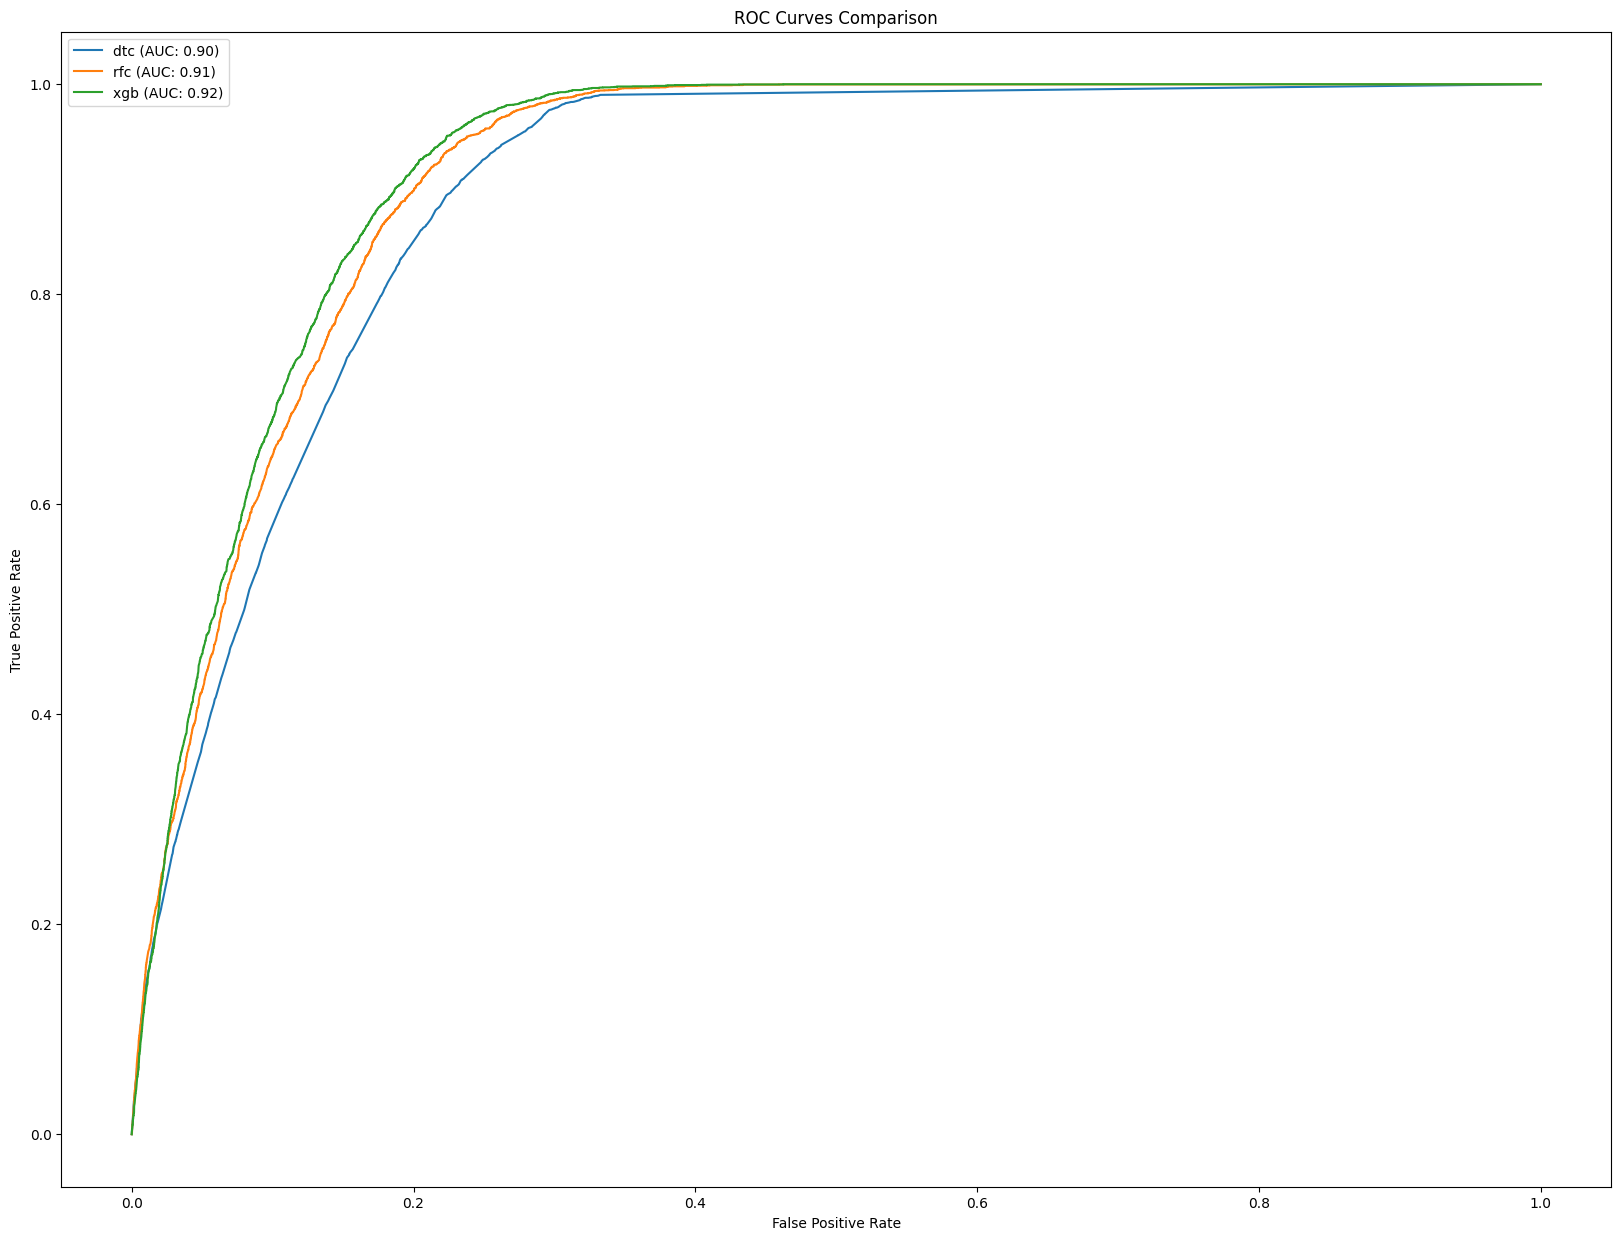

In [37]:
plt.figure(figsize=(20, 15))

model_names = ["dtc", "rfc", "xgb"]
models = [dtc_model, rfc_model, xgb_model]

for i, model in enumerate(models):
    fpr, tpr, _ = roc_curve(ytest, model.predict_proba(xtest)[:, 1])
    plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC: {roc_auc_score(ytest, model.predict_proba(xtest)[:, 1]):.2f})')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.show()

# Statistical Comparison

In [ ]:
cv_scores = {name: cross_val_score(model, xtest, ytest, scoring='accuracy', cv=7) for name, model in zip(model_names, models)}

In [ ]:
cv_scores

In [ ]:
print(f"rfc: {np.mean(cv_scores['rfc'])}")
print(f"xgb: {np.mean(cv_scores['xgb'])}")

In [ ]:
t_stat, p_val = ttest_rel(cv_scores['rfc'], cv_scores['xgb'])
print(f"Paired t-test between rfc and xgb: t-stat = {t_stat:.3f}, p-val = {p_val:.8f}")

# Explainability

In [ ]:
import shap

preprocessor = xgb_model.named_steps["preprocessor"]
xgb_clf = xgb_model.named_steps["xgb"]
idx = [15454, 1284, 30305]

In [ ]:
xtest.iloc[idx[0]]

In [ ]:
shap.plots.force(
    base_value=,
    shap_values=None,
    features=None,
    feature_names=None,
    out_names=None,
    link='identity', # "logit"
    plot_cmap='RdBu',
    matplotlib=False,
    show=True
)

In [ ]:
import shap

preprocessor = xgb_model.named_steps["preprocessor"]
xgb_clf = xgb_model.named_steps["xgb"]
xtest_preprocessed = preprocessor.transform(xtest)

# idx = np.random.choice(np.where(ytest == 0)[0], size=1, replace=False)
idx = [15454, 1284, 30305]
observation = xtest_preprocessed[idx[1]].reshape(1, -1)
observation_original = np.array(xtest.iloc[idx[1],:]).reshape(1, -1)

explainer = shap.TreeExplainer(xgb_clf)
shap_value_obs = explainer.shap_values(observation)

# shap.initjs()
plt.figure(figsize=(60, 20))
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_value_obs,
    features=observation_original,
    feature_names=config.features,
    matplotlib=True
)

In [ ]:
explainer.expected_value

In [ ]:
shap.plots.decision(
    base_value=explainer.expected_value,
    shap_values=shap_value_obs,
    features=observation_original,
    feature_names=config.features,
    feature_order="importance",
    show=True
)

explainer = shap.Explainer(xgb_clf, xtest_preprocessed)
shap_values = explainer(xtest_preprocessed)

with open("shap_values.pkl", "wb") as file:
    pickle.dump(shap_values, file)

In [ ]:
with open("shap_values.pkl", "rb") as file:
    shap_values = pickle.load(file)
shap_values.feature_names = config.features

In [ ]:
shap.plots.waterfall(
    shap_values[23325],
    max_display=len(config.features)
)

In [ ]:
shap.plots.bar(
    shap_values[23325],
    max_display=len(config.features)
)

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(xgb_clf, random_state=1).fit(xtest_preprocessed, ytest)
eli5.show_weights(perm, feature_names = xtest.columns.tolist())


In [ ]:
from xgboost import plot_importance
xgb_clf.get_booster().feature_names = config.features
plt.figure(figsize=(30,15))
plot_importance(
    xgb_clf,
    grid=False,
    importance_type="gain"
)